In [1]:
import numpy as np
from numba import jit
from typing import List, Tuple, Optional, Set, Union
from dataclasses import dataclass
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.animation as animation


DIM_GRID=6 #4x4
COMPLEX_OF_PROBLEM=500 #if increase i mix more the initial state starting from the goal

In [2]:


@dataclass(frozen=True)
class PuzzleState:
    """Immutable puzzle state using a flat array representation for efficiency"""
    board: tuple
    blank_pos: int
    size: int
    
    @classmethod
    def from_2d(cls, board_2d: np.ndarray):
        """Create a PuzzleState from a 2D numpy array"""
        size = len(board_2d)
        flat = tuple(board_2d.flatten())
        blank_pos = flat.index(0)
        return cls(flat, blank_pos, size)
    
    def to_2d(self) -> np.ndarray:
        """Convert to 2D numpy array for display"""
        return np.array(self.board).reshape(self.size, self.size)

    def __hash__(self):
        return hash(self.board)

@jit(nopython=True)
def manhattan_distance(state: np.ndarray, goal_positions: np.ndarray, size: int) -> int:
    """Optimized Manhattan distance calculation with Numba"""
    distance = 0
    for pos, val in enumerate(state):
        if val != 0:
            curr_row, curr_col = pos // size, pos % size
            goal_pos = goal_positions[val]
            goal_row, goal_col = goal_pos // size, goal_pos % size
            distance += abs(curr_row - goal_row) + abs(curr_col - goal_col)
    return distance



@jit(nopython=True)
def detect_linear_conflicts(state: np.ndarray, goal_positions: np.ndarray, size: int) -> int:
    """Optimized linear conflict detection with Numba"""
    conflicts = 0
    
    # Check rows
    for row in range(size):
        for i in range(size):
            pos1 = row * size + i
            val1 = state[pos1]
            if val1 == 0:
                continue
                
            goal_pos1 = goal_positions[val1]
            goal_row1, goal_col1 = goal_pos1 // size, goal_pos1 % size
            if goal_row1 != row:
                continue
                
            for j in range(i + 1, size):
                pos2 = row * size + j
                val2 = state[pos2]
                if val2 == 0:
                    continue
                    
                goal_pos2 = goal_positions[val2]
                goal_row2, goal_col2 = goal_pos2 // size, goal_pos2 % size
                if goal_row2 == row and goal_col2 < goal_col1:
                    conflicts += 2

    # Check columns
    for col in range(size):
        for i in range(size):
            pos1 = i * size + col
            val1 = state[pos1]
            if val1 == 0:
                continue
                
            goal_pos1 = goal_positions[val1]
            goal_row1, goal_col1 = goal_pos1 // size, goal_pos1 % size
            if goal_col1 != col:
                continue
                
            for j in range(i + 1, size):
                pos2 = j * size + col
                val2 = state[pos2]
                if val2 == 0:
                    continue
                    
                goal_pos2 = goal_positions[val2]
                goal_row2, goal_col2 = goal_pos2 // size, goal_pos2 % size
                if goal_col2 == col and goal_row2 < goal_row1:
                    conflicts += 2
                    
    return conflicts

def calculate_weights(size: int) -> np.ndarray:
    """Calculate weights for each tile based on proximity to center"""
    weights = np.ones(size * size, dtype=np.float32)
    center_row, center_col = size // 2, size // 2
    for i in range(size * size):
        if i == 0:
            continue
        row, col = divmod(i, size)
        distance_from_center = abs(row - center_row) + abs(col - center_col)
        weights[i] = 1 + 0.1 * distance_from_center  # Aumenta il peso man mano che ci si allontana dal centro
    return weights

@jit(nopython=True)
def weighted_manhattan_distance(state: np.ndarray, goal_positions: np.ndarray, size: int, weights: np.ndarray) -> int:
    """Weighted Manhattan distance calculation"""
    distance = 0
    for pos, val in enumerate(state):
        if val != 0:
            curr_row, curr_col = pos // size, pos % size
            goal_pos = goal_positions[val]
            goal_row, goal_col = goal_pos // size, goal_pos % size
            manhattan = abs(curr_row - goal_row) + abs(curr_col - goal_col)
            distance += manhattan * weights[val]
    return distance

class NPuzzleSolver:
    def __init__(self, size: int, goal_state: np.ndarray):
        self.size = size
        self.goal_state = PuzzleState.from_2d(goal_state)
        self._precompute_goal_positions()
        self._precompute_moves()
        
    def _precompute_goal_positions(self):
        """Precompute goal positions for faster heuristic calculation"""
        # Create an array where index is the tile value and value is the position
        self.goal_positions = np.zeros(self.size * self.size, dtype=np.int32)
        for pos, val in enumerate(self.goal_state.board):
            if val != 0:
                self.goal_positions[val] = pos
        
    def _precompute_moves(self):
        """Precompute all possible moves for each blank position"""
        self.possible_moves = {}
        for pos in range(self.size * self.size):
            row, col = pos // self.size, pos % self.size
            moves = []
            
            if row > 0:
                moves.append(pos - self.size)  # up
            if row < self.size - 1:
                moves.append(pos + self.size)  # down
            if col > 0:
                moves.append(pos - 1)  # left
            if col < self.size - 1:
                moves.append(pos + 1)  # right
                
            self.possible_moves[pos] = moves
    
    def _generate_moves(self, state: PuzzleState) -> List[PuzzleState]:
        """Generate possible moves using precomputed positions"""
        moves = []
        board_list = list(state.board)
        
        for new_blank_pos in self.possible_moves[state.blank_pos]:
            new_board = board_list.copy()
            new_board[state.blank_pos], new_board[new_blank_pos] = \
                new_board[new_blank_pos], new_board[state.blank_pos]
            moves.append(PuzzleState(tuple(new_board), new_blank_pos, self.size))
            
        return moves
    
    def _calculate_heuristic(self, state: PuzzleState) -> int:
        """Calculate combined heuristic (Manhattan + Linear Conflicts)"""
        state_array = np.array(state.board, dtype=np.int32)
        
        if DIM_GRID<=4:
            return (manhattan_distance(state_array, self.goal_positions, self.size) + detect_linear_conflicts(state_array, self.goal_positions, self.size))
        else:
            return (manhattan_distance(state_array, self.goal_positions, self.size)  + detect_linear_conflicts(state_array, self.goal_positions, self.size)+weighted_manhattan_distance(state_array, self.goal_positions, self.size, calculate_weights( self.size)))
        
        
    def solve(self, initial_state: np.ndarray, max_iterations: int = 500_000) -> Optional[List[PuzzleState]]:
        """Solve using IDA* (Iterative Deepening A*)"""
        initial = PuzzleState.from_2d(initial_state)
        threshold = self._calculate_heuristic(initial)
        path = deque([initial])
        visited = set()
        
        for _ in range(max_iterations):
            distance = self._ida_search(path, 0, threshold, visited)
            if distance is True:
                return list(path)
            if distance == float('inf'):
                return None
            threshold = distance
            visited.clear()
            
        return None
    
    def _ida_search(self, path: deque, g: int, threshold: int, visited: Set[int]) -> Union[bool, float]:
        
        node = path[-1]
        f = g + self._calculate_heuristic(node)

        if f > threshold:
            return f
        if node == self.goal_state:
            return True

        state_hash = hash(node)
        if state_hash in visited:
            return float('inf')

        visited.add(state_hash)
        min_cost = float('inf')

        for move in self._generate_moves(node):
            if hash(move) not in visited:
                path.append(move)
                t = self._ida_search(path, g + 1, threshold, visited)
                if t is True:
                    return True
                if t < min_cost:
                    min_cost = t
                path.pop()

        visited.remove(state_hash)
        return min_cost

    
def generate_random_initial_state(goal_state: np.ndarray, num_moves: int = 100) -> np.ndarray:
    
    # Create a mutable copy of the goal state
    current_state = goal_state.copy()
    size = current_state.shape[0]
    
    # Find initial blank (zero) position
    blank_row, blank_col = np.where(current_state == 0)
    blank_row, blank_col = int(blank_row[0]), int(blank_col[0])
    
    # Possible move directions: up, down, left, right
    moves = [
        (-1, 0),  # up
        (1, 0),   # down
        (0, -1),  # left
        (0, 1)    # right
    ]
    
    # Random seed for reproducibility
    np.random.seed(None)  # Use system time as seed
    
    # Perform random moves
    for _ in range(num_moves):
        # Shuffle moves to add randomness
        np.random.shuffle(moves)
        
        # Try moves until a valid one is found
        for dr, dc in moves:
            new_row = blank_row + dr
            new_col = blank_col + dc
            
            # Check if move is valid
            if 0 <= new_row < size and 0 <= new_col < size:
                # Swap blank with the tile in the new position
                current_state[blank_row, blank_col], current_state[new_row, new_col] = \
                    current_state[new_row, new_col], current_state[blank_row, blank_col]
                
                # Update blank position
                blank_row, blank_col = new_row, new_col
                break
    
    return current_state

def generate_goal_state(size: int) -> np.ndarray:
    """Genera automaticamente il goal state per un puzzle di dimensione size x size."""
    goal = np.arange(1, size * size)  # Riempie con i numeri da 1 a size*size-1
    goal = np.append(goal, 0)  # Aggiunge 0 alla fine
    return goal.reshape(size, size)



In [3]:

goal_state = generate_goal_state(DIM_GRID) 

# Generate a random initial state
initial_state = generate_random_initial_state(goal_state,COMPLEX_OF_PROBLEM)
"""
example initial state DIMGRID=4
initial_state=np.array([[ 2, 12, 10 , 1],
 [14, 15 , 8 , 7],
 [ 0, 13 , 6, 11],
 [ 5,  9 , 3 , 4]])

if you want to insert a initial state write a int matrix

"""



print("Initial State:")
print(initial_state)
solver = NPuzzleSolver(DIM_GRID, goal_state)
solution = solver.solve(initial_state)

if solution:
    print(f"\nSolution found in {len(solution)-1} moves:")
    for i, state in enumerate(solution):
        print(f"\nStep {i}:")
        print(state.to_2d())
else:
    print("No solution found")
    
    

Initial State:
[[ 9  8  3  6 12 18]
 [20 13  5 27 11 22]
 [15 28 26  7  4 23]
 [32  2 21 17 30 14]
 [ 0  1 33 10 29 24]
 [25 31 19 34 16 35]]

Solution found in 174 moves:

Step 0:
[[ 9  8  3  6 12 18]
 [20 13  5 27 11 22]
 [15 28 26  7  4 23]
 [32  2 21 17 30 14]
 [ 0  1 33 10 29 24]
 [25 31 19 34 16 35]]

Step 1:
[[ 9  8  3  6 12 18]
 [20 13  5 27 11 22]
 [15 28 26  7  4 23]
 [32  2 21 17 30 14]
 [25  1 33 10 29 24]
 [ 0 31 19 34 16 35]]

Step 2:
[[ 9  8  3  6 12 18]
 [20 13  5 27 11 22]
 [15 28 26  7  4 23]
 [32  2 21 17 30 14]
 [25  1 33 10 29 24]
 [31  0 19 34 16 35]]

Step 3:
[[ 9  8  3  6 12 18]
 [20 13  5 27 11 22]
 [15 28 26  7  4 23]
 [32  2 21 17 30 14]
 [25  1 33 10 29 24]
 [31 19  0 34 16 35]]

Step 4:
[[ 9  8  3  6 12 18]
 [20 13  5 27 11 22]
 [15 28 26  7  4 23]
 [32  2 21 17 30 14]
 [25  1  0 10 29 24]
 [31 19 33 34 16 35]]

Step 5:
[[ 9  8  3  6 12 18]
 [20 13  5 27 11 22]
 [15 28 26  7  4 23]
 [32  2  0 17 30 14]
 [25  1 21 10 29 24]
 [31 19 33 34 16 35]]

Step 6:
[[ 


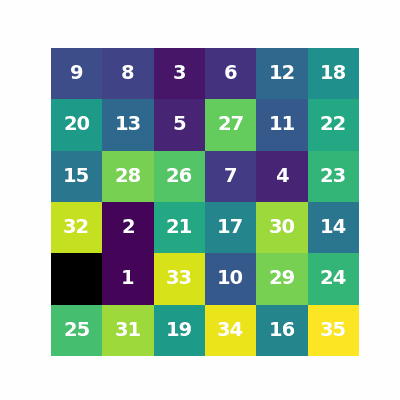

In [4]:
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tempfile
import shutil
import os
import base64
import numpy as np

def animate_solution_jupyter(solution: List[PuzzleState], interval: int = 500):
    """
    Create an animation to visualize the solution steps in a Jupyter Notebook.
    
    Args:
        solution: List of PuzzleState objects representing the solution steps.
        interval: Time in milliseconds between frames (default: 500ms).
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.axis('off')  # Hide axes
    size = solution[0].size  # Get the puzzle size

    # Use a soft colormap like 'viridis' for a more pleasing visual appearance
    colormap = plt.cm.viridis

    # Initialize the image with the first state
    state_2d = solution[0].to_2d()
    
    # Create a color map where we map 0 to black, and the rest to 'viridis'
    color_map = np.zeros_like(state_2d, dtype=float)
    unique_values = np.unique(state_2d[state_2d != 0])  # Get all unique non-zero values
    
    # Create a custom colormap for the non-zero values
    color_list = colormap(np.linspace(0, 1, len(unique_values)))
    value_to_color = dict(zip(unique_values, color_list))
    
    for row in range(size):
        for col in range(size):
            val = state_2d[row, col]
            if val != 0:
                color_map[row, col] = np.where(unique_values == val)[0][0]  # Map value to color index
            else:
                color_map[row, col] = -1  # Mark 0-value cells to be black

    # Create a custom colormap where -1 is black
    custom_colormap = plt.cm.colors.ListedColormap(['black'] + list(color_list))

    im = ax.imshow(color_map, cmap=custom_colormap, interpolation='nearest', aspect='equal', vmin=-1, vmax=len(unique_values))

    # Add text annotations for tile values with improved styling
    annotations = [
        ax.text(
            col, row, str(state_2d[row, col]) if state_2d[row, col] != 0 else '',
            ha='center', va='center', color='white', fontsize=14, weight='bold', 
            family='sans-serif'
        )
        for row in range(size) for col in range(size)
    ]

    def update(frame: int):
        """Update function for the animation"""
        state_2d = solution[frame].to_2d()
        
        # Update the color map based on the current state
        color_map = np.zeros_like(state_2d, dtype=float)
        for row in range(size):
            for col in range(size):
                val = state_2d[row, col]
                if val != 0:
                    color_map[row, col] = np.where(unique_values == val)[0][0]
                else:
                    color_map[row, col] = -1  # Mark 0-value cells to be black

        im.set_data(color_map)  # Update the image
        
        # Update the annotations (text labels for numbers)
        for row in range(size):
            for col in range(size):
                val = state_2d[row, col]
                annotations[row * size + col].set_text(str(val) if val != 0 else '')

    # Create the animation
    anim = animation.FuncAnimation(
        fig, update, frames=len(solution), interval=interval, repeat=False
    )

    # Save the animation as a GIF in a temporary file
    temp_dir = tempfile.mkdtemp()  # Create a temporary directory
    gif_path = os.path.join(temp_dir, "animation.gif")
    
    anim.save(gif_path, writer="pillow", fps=1000 / interval)
    
    # Read the gif file and encode it in base64
    with open(gif_path, "rb") as f:
        data = f.read()
    gif_base64 = base64.b64encode(data).decode('utf-8')  # Encoding the GIF in Base64
    
    # Display the GIF in the notebook
    display(HTML(f'<img src="data:image/gif;base64,{gif_base64}" width="400">'))
    
    # Clean up temporary files
    shutil.rmtree(temp_dir)

    # Ensure that the figure is closed to avoid warnings
    plt.close(fig)


if solution: 
    animate_solution_jupyter(solution)
